In [2]:
import pandas as pd
import lightgbm as lgb
import numpy as np
from sklearn.metrics import roc_auc_score, average_precision_score
from category_encoders import TargetEncoder

In [3]:
df_labeled=pd.read_csv("../Processed Data/prd_loyal_customers.csv")
df_labeled.drop(columns=['is_repeat_customer', 'is_repeat_customer', 'days_since_last_order','is_first_order'], inplace=True)

In [4]:
df = df_labeled.copy()
df["snapshot_date"] = pd.to_datetime(df["snapshot_date"], errors="coerce")
split_point = df["snapshot_date"].quantile(0.8)

train_idx = df["snapshot_date"] < split_point
test_idx  = df["snapshot_date"] >= split_point

In [5]:
score = df["avg_review_score"].fillna(-1)
length = df["avg_review_length"].fillna(0)

conditions = [
    (score >= 4) & (length > 0),                    # 5: Vocal Promoter
    (score >= 4) & (length == 0),                   # 4: Silent Satisfied
    (score == -1),                                  # 3: Ghost
    (score > 2) & (score < 4),                      # 2: Passive
    (score <= 2) & (score > 0) & (length == 0),     # 1: Quiet Detractor
    (score <= 2) & (score > 0) & (length > 0)       # 0: Vocal Detractor
]
choices = [5, 4, 3, 2, 1, 0]

df["sentiment_index"] = np.select(conditions, choices, default=3).astype(int)

# You can drop raw length if you want
df = df.drop(columns=["avg_review_length"], errors="ignore")


In [6]:
df["main_category"] = df["main_category"].fillna("unknown").astype(str)

state_lookup = df.loc[train_idx].groupby("customer_state")["total_order_value"].mean()
cat_lookup   = df.loc[train_idx].groupby("main_category")["total_order_value"].mean()
global_avg   = df.loc[train_idx, "total_order_value"].mean()

df["state_avg"] = df["customer_state"].map(state_lookup).fillna(global_avg)
df["cat_avg"]   = df["main_category"].map(cat_lookup).fillna(global_avg)

df["value_ratio"]           = df["total_order_value"] / df["state_avg"]
df["val_ratio_vs_category"] = df["total_order_value"] / df["cat_avg"]
df["freight_ordervalue_ratio"] = df["total_freight_value"] / df["total_order_value"].replace(0, np.nan)

In [7]:
eps = 1e-6

df["price_spread_ratio"]      = df["max_price"] / (df["min_price"] + eps)
df["order_value_spread_ratio"]= df["max_order_value"] / (df["min_order_value"] + eps)

df["weight_spread_ratio"]     = df["max_weight"] / (df["avg_weight"] + eps)   # since no min_weight
df["volume_spread_ratio"]     = df["max_volume"] / (df["avg_volume"] + eps)

In [8]:
for c in ["price_spread_ratio","order_value_spread_ratio","weight_spread_ratio","volume_spread_ratio"]:
    df[c] = df[c].clip(upper=50)  

In [9]:
# List of columns to drop
drop_cols = [
    'label_is_loyal',           
    'customer_id', 'order_id', 'customer_unique_id',
    'order_purchase_timestamp', 'snapshot_date',    
    'past_order_count',        
    'customer_city',           
    'min_price', 'max_price',  
    'min_order_value', 'max_order_value',
    'max_weight', 'max_volume', 
    'min_review_score', 'max_review_score', 
    'geolocation_lat', 'geolocation_lng', "is_latlng_missing","customer_state",
    "customer_zip_code_prefix","total_freight_value","avg_freight_value","total_order_value","state_avg","total_payment_value",
    "tot_sellers_in_zip","tot_customers_in_zip"
]


X = df.drop(columns=drop_cols, errors='ignore')
y = df['label_is_loyal']


print(X.select_dtypes(include=['object']).columns)

Index(['main_category'], dtype='object')


In [10]:
import pandas as pd

# 1. Force conversion to datetime immediately
df["snapshot_date"] = pd.to_datetime(df_labeled["snapshot_date"], errors="coerce")

# 2. Sort chronologically
df = df.sort_values("snapshot_date").copy()

# 3. Define the Cutoffs based on actual dates
# 80th percentile for the Final Test set
test_cutoff = df["snapshot_date"].quantile(0.8)
# 60th percentile for the Validation set
val_cutoff = df["snapshot_date"].quantile(0.6)

# 4. Assign Indices
train_idx = df["snapshot_date"] < val_cutoff
val_idx   = (df["snapshot_date"] >= val_cutoff) & (df["snapshot_date"] < test_cutoff)
test_idx  = df["snapshot_date"] >= test_cutoff

# 5. Create the Sets
X_train, y_train = X[train_idx].copy(), y[train_idx].copy()
X_val,   y_val   = X[val_idx].copy(),   y[val_idx].copy()
X_test,  y_test  = X[test_idx].copy(),  y[test_idx].copy()

print(f"Training Range: {df.loc[train_idx, 'snapshot_date'].min()} to {df.loc[train_idx, 'snapshot_date'].max()}")
print(f"Test Range:     {df.loc[test_idx, 'snapshot_date'].min()} to {df.loc[test_idx, 'snapshot_date'].max()}")

Training Range: 2016-09-03 21:15:19 to 2018-03-01 13:34:44
Test Range:     2018-05-23 18:04:31 to 2018-08-28 15:00:37


/var/folders/jr/cx9v05mj76767q_pxc111nvr0000gn/T/ipykernel_74203/3611180768.py:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  X_train, y_train = X[train_idx].copy(), y[train_idx].copy()
/var/folders/jr/cx9v05mj76767q_pxc111nvr0000gn/T/ipykernel_74203/3611180768.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  X_val,   y_val   = X[val_idx].copy(),   y[val_idx].copy()
/var/folders/jr/cx9v05mj76767q_pxc111nvr0000gn/T/ipykernel_74203/3611180768.py:23: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  X_test,  y_test  = X[test_idx].copy(),  y[test_idx].copy()


In [ ]:
from category_encoders import TargetEncoder


te = TargetEncoder(cols=["main_category"], smoothing=5)
X_train["main_category"] = te.fit_transform(X_train["main_category"], y_train)

X_val["main_category"] = te.transform(X_val["main_category"])
X_test["main_category"] = te.transform(X_test["main_category"])

X_train["main_category"] = X_train["main_category"].fillna(y_train.mean())
X_val["main_category"]   = X_val["main_category"].fillna(y_train.mean())
X_test["main_category"]  = X_test["main_category"].fillna(y_train.mean())

In [12]:
print("Loyalty score for top categories in Train:")
print(X_train["main_category"].value_counts().head())

Loyalty score for top categories in Train:
main_category
0.061299    5514
0.049468    4609
0.041834    4470
0.041250    3903
0.058486    3830
Name: count, dtype: int64


In [21]:
import xgboost as xgb
from sklearn.metrics import average_precision_score

# 1. Recalculate the imbalance ratio (if not already done)
neg_count = (y_train == 0).sum()
pos_count = (y_train == 1).sum()
spw = neg_count / pos_count

# 2. Initialize with early_stopping_rounds INSIDE the constructor
model = xgb.XGBClassifier(
    n_estimators=1000,
    max_depth=5,
    learning_rate=0.05,
    scale_pos_weight=spw,
    objective='binary:logistic',
    eval_metric='aucpr',
    # --- Move early_stopping_rounds here ---
    early_stopping_rounds=50, 
    random_state=42,
    tree_method='hist'
)

# 3. Fit the model (pass the eval_set as before, but remove early_stopping_rounds)
model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    verbose=True
)

# 4. Final Evaluation
y_probs = model.predict_proba(X_test)[:, 1]
final_pr_auc = average_precision_score(y_test, y_probs)

print(f"\nFinal PR-AUC on Hold-out Test Set: {final_pr_auc:.4f}")

[0]	validation_0-aucpr:0.05446
[1]	validation_0-aucpr:0.05535
[2]	validation_0-aucpr:0.05742
[3]	validation_0-aucpr:0.05799
[4]	validation_0-aucpr:0.05672
[5]	validation_0-aucpr:0.05692
[6]	validation_0-aucpr:0.05677
[7]	validation_0-aucpr:0.05652
[8]	validation_0-aucpr:0.05635
[9]	validation_0-aucpr:0.05628
[10]	validation_0-aucpr:0.05600
[11]	validation_0-aucpr:0.05586
[12]	validation_0-aucpr:0.05654
[13]	validation_0-aucpr:0.05475
[14]	validation_0-aucpr:0.05506
[15]	validation_0-aucpr:0.05516
[16]	validation_0-aucpr:0.05541
[17]	validation_0-aucpr:0.05631
[18]	validation_0-aucpr:0.05641
[19]	validation_0-aucpr:0.05658
[20]	validation_0-aucpr:0.05691
[21]	validation_0-aucpr:0.05711
[22]	validation_0-aucpr:0.05724
[23]	validation_0-aucpr:0.05710
[24]	validation_0-aucpr:0.05723
[25]	validation_0-aucpr:0.05519
[26]	validation_0-aucpr:0.05550
[27]	validation_0-aucpr:0.05669
[28]	validation_0-aucpr:0.05655
[29]	validation_0-aucpr:0.05667
[30]	validation_0-aucpr:0.05688
[31]	validation_0-

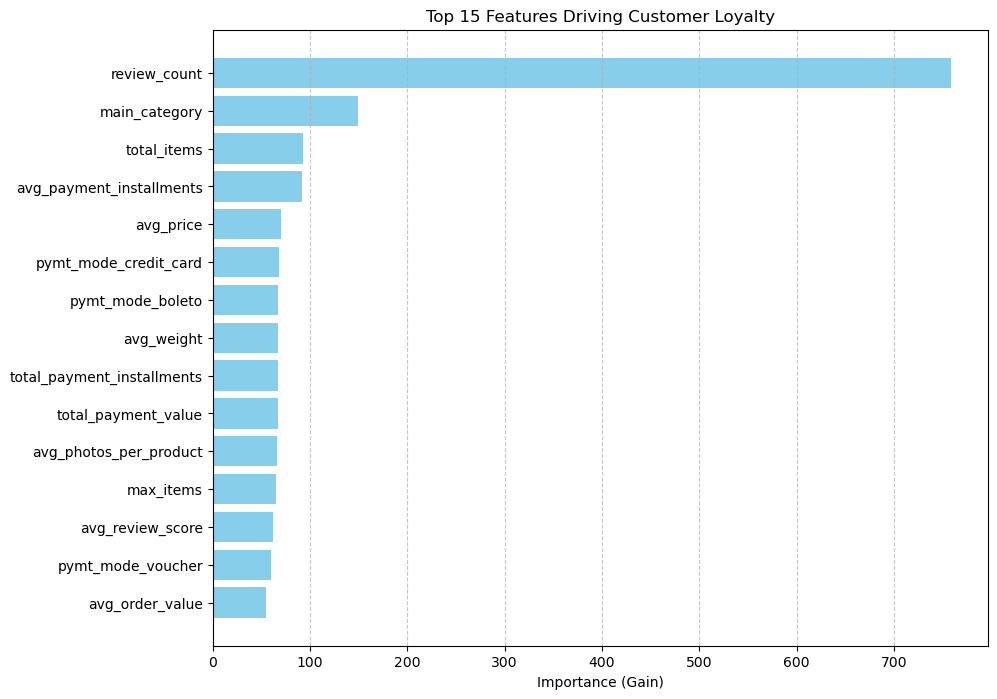

In [34]:
import matplotlib.pyplot as plt
import pandas as pd

# 1. Extract importance (using Gain)
importance = model.get_booster().get_score(importance_type='gain')

# 2. Convert to a sorted DataFrame
importance_df = pd.DataFrame({
    'Feature': importance.keys(),
    'Importance': importance.values()
}).sort_values(by='Importance', ascending=False)

# 3. Plot the Top 15 features
plt.figure(figsize=(10, 8))
plt.barh(importance_df['Feature'].head(15), importance_df['Importance'].head(15), color='skyblue')
plt.xlabel('Importance (Gain)')
plt.title('Top 15 Features Driving Customer Loyalty')
plt.gca().invert_yaxis()  # Highest importance at the top
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

In [22]:
import numpy as np

def focal_loss_objective(y_true, y_pred, gamma=2.0, alpha=0.25):

    preds = 1.0 / (1.0 + np.exp(-y_pred))
    
   
    pos_factor = alpha * (1 - preds)**gamma
    neg_factor = (1 - alpha) * preds**gamma
    
    grad = y_true * pos_factor * (preds - 1) + (1 - y_true) * neg_factor * preds
    

    hess = y_true * pos_factor * preds * (1 - preds) + (1 - y_true) * neg_factor * preds * (1 - preds)
    
    return grad, hess


model_focal = xgb.XGBClassifier(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=6,
    tree_method='hist',
    early_stopping_rounds=50
)

model_focal.set_params(objective=focal_loss_objective)

model_focal.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    verbose=False
)

,"objective objective: typing.Union[str, xgboost.sklearn._SklObjWProto, typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]], NoneType]Specify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",<function foc...t 0x31245f7e0>
,"base_score base_score: typing.Union[float, typing.List[float], NoneType]The initial prediction score of all instances, global bias.",None
,booster,None
,"callbacks callbacks: typing.Optional[typing.List[xgboost.callback.TrainingCallback]]List of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: typing.Optional[float]Subsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: typing.Optional[float]Subsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: typing.Optional[float]Subsample ratio of columns when constructing each tree.,None
,"device device: typing.Optional[str].. versionadded:: 2.0.0Device ordinal, available options are `cpu`, `cuda`, and `gpu`.",None
,"early_stopping_rounds early_stopping_rounds: typing.Optional[int].. versionadded:: 1.6.0- Activates early stopping. Validation metric needs to improve at least once in every **early_stopping_rounds** round(s) to continue training. Requires at least one item in **eval_set** in :py:meth:`fit`.- If early stopping occurs, the model will have two additional attributes: :py:attr:`best_score` and :py:attr:`best_iteration`. These are used by the :py:meth:`predict` and :py:meth:`apply` methods to determine the optimal number of trees during inference. If users want to access the full model (including trees built after early stopping), they can specify the `iteration_range` in these inference methods. In addition, other utilities like model plotting can also use the entire model.- If you prefer to discard the trees after `best_iteration`, consider using the callback function :py:class:`xgboost.callback.EarlyStopping`.- If there's more than one item in **eval_set**, the last entry will be used for early stopping. If there's more than one metric in **eval_metric**, the last metric will be used for early stopping.",50
,enable_categorical enable_categorical: boolSee the same parameter of :py:class:`DMatrix` for details.,False
,"eval_metric eval_metric: typing.Union[str, typing.List[typing.Union[str, typing.Callable]], typing.Callable, NoneType].. versionadded:: 1.6.0Metric used for monitoring the training result and early stopping. It can be astring or list of strings as names of predefined metric in XGBoost (See:doc:`/parameter`), one of the metrics in :py:mod:`sklearn.metrics`, or anyother user defined metric that looks like `sklearn.metrics`.If custom objective is also provided, then custom metric should implement thecorresponding reverse link function.Unlike the `scoring` parameter commonly used in scikit-learn, when a callableobject is provided, it's assumed to be a cost function and by default XGBoostwill minimize the result during early stopping.For advanced usage on Early stopping like directly choosing to maximize insteadof minimize, see :py:obj:`xgboost.callback.EarlyStopping`.See :doc:`/tutorials/custom_metric_obj` and :ref:`custom-obj-metric` for moreinformation... code-block:: python from sklearn.datasets import loa

In [23]:
# --- STEP 1: Train LightGBM (Standard/Balanced) ---
lgb_model = lgb.LGBMClassifier(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=5,
    is_unbalance=True,      # This is LGBM's way of handling the imbalance
    objective='binary',
    metric='auc',           # Helps it stay stable during training
    importance_type='gain',
    random_state=42,
    verbosity=-1
)

lgb_model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    callbacks=[lgb.early_stopping(stopping_rounds=50)]
)

# --- STEP 2: Get Predictions (Ensure you use Focal XGB) ---
# Use the model_focal we just built!
xgb_focal_probs = model_focal.predict_proba(X_test)[:, 1] 
lgb_probs = lgb_model.predict_proba(X_test)[:, 1]

# --- STEP 3: Ensemble ---
# Try a 60/40 split favoring the Focal Loss model, which is better at "hard" cases
ensemble_probs = (0.6 * xgb_focal_probs) + (0.4 * lgb_probs)

# --- STEP 4: Evaluate ---
from sklearn.metrics import average_precision_score

print(f"Focal XGBoost PR-AUC: {average_precision_score(y_test, xgb_focal_probs):.4f}")
print(f"LightGBM PR-AUC:     {average_precision_score(y_test, lgb_probs):.4f}")
print(f"Ensemble PR-AUC:      {average_precision_score(y_test, ensemble_probs):.4f}")

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[29]	valid_0's auc: 0.611425
Focal XGBoost PR-AUC: 0.0625
LightGBM PR-AUC:     0.0804
Ensemble PR-AUC:      0.0705


In [24]:
from scipy.stats import rankdata

# Convert probabilities to ranks (0.0 to 1.0 scale)
xgb_rank = rankdata(xgb_focal_probs) / len(xgb_focal_probs)
lgb_rank = rankdata(lgb_probs) / len(lgb_probs)

# Blend the ranks
rank_ensemble = (0.6 * xgb_rank) + (0.4 * lgb_rank)

# Check the score
from sklearn.metrics import average_precision_score
print(f"Rank-Based Ensemble PR-AUC: {average_precision_score(y_test, rank_ensemble):.4f}")

Rank-Based Ensemble PR-AUC: 0.0728


In [25]:
import pandas as pd

# 1. Create a results dataframe
results = pd.DataFrame({
    'actual': y_test,
    'prob': rank_ensemble
})

# 2. Divide into 10 equal groups (Deciles)
results['decile'] = pd.qcut(results['prob'], 10, labels=False, duplicates='drop')

# 3. Calculate the hit rate (loyalty rate) per decile
lift_df = results.groupby('decile')['actual'].mean().reset_index()
lift_df = lift_df.sort_values('decile', ascending=False) # Top decile first
lift_df['lift'] = lift_df['actual'] / y_test.mean()

print("--- Lift per Decile ---")
print(lift_df[['decile', 'actual', 'lift']])

--- Lift per Decile ---
   decile    actual      lift
9       9  0.024737  2.292442
8       8  0.008947  0.829181
7       7  0.009474  0.877956
6       6  0.012652  1.172460
5       5  0.008938  0.828309
4       4  0.010526  0.975507
3       3  0.007372  0.683215
2       2  0.007895  0.731630
1       1  0.009474  0.877956
0       0  0.007895  0.731630


In [26]:
from catboost import CatBoostClassifier

# --- STEP 1: Train CatBoost ---
# Identify indices of categorical columns if they aren't encoded yet
# If they are already encoded, CatBoost still treats them well as numericals
cat_model = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.05,
    depth=6,
    l2_leaf_reg=5,
    bootstrap_type='Bernoulli',
    subsample=0.8,
    eval_metric='AUC',
    random_seed=42,
    verbose=100,
    early_stopping_rounds=50
)

cat_model.fit(
    X_train, y_train,
    eval_set=(X_val, y_val)
)

# --- STEP 2: Get Probabilities ---
cat_probs = cat_model.predict_proba(X_test)[:, 1]

# --- STEP 3: The Optimized Triple-Blend ---
# Giving LightGBM the most weight (MVP), then CatBoost, then Focal XGB
xgb_rank = rankdata(xgb_focal_probs) / len(xgb_focal_probs)
lgb_rank = rankdata(lgb_probs) / len(lgb_probs)
cat_rank = rankdata(cat_probs) / len(cat_probs)

# Try a 50/30/20 split
final_ensemble_rank = (0.5 * lgb_rank) + (0.3 * cat_rank) + (0.2 * xgb_rank)

# --- STEP 4: Final Evaluation ---
print(f"CatBoost PR-AUC: {average_precision_score(y_test, cat_probs):.4f}")
print(f"Triple Ensemble PR-AUC: {average_precision_score(y_test, final_ensemble_rank):.4f}")

0:	test: 0.5297001	best: 0.5297001 (0)	total: 62.9ms	remaining: 1m 2s
100:	test: 0.6219188	best: 0.6219188 (100)	total: 578ms	remaining: 5.15s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6236321709
bestIteration = 133

Shrink model to first 134 iterations.
CatBoost PR-AUC: 0.0786
Triple Ensemble PR-AUC: 0.0781


In [28]:
X_train

,tot_customers_in_zip,tot_sellers_in_zip,n_distinct_categories,main_category,avg_photos_per_product,avg_desc_length,avg_weight,avg_volume,total_price,avg_price,...,sentiment_index,state_avg,cat_avg,value_ratio,val_ratio_vs_category,freight_ordervalue_ratio,price_spread_ratio,order_value_spread_ratio,weight_spread_ratio,volume_spread_ratio
2,7.0,1.0,1.0,0.026410,3.0,177.0,1500.0,43750.0,69.00,69.00,...,2,164.244218,121.416330,0.524950,0.710119,0.199722,1.000000,1.000000,1.000000,1.000000
3,7.0,0.0,1.0,0.029246,5.0,1741.0,150.0,1045.0,25.99,25.99,...,5,221.099439,82.899088,0.197287,0.526182,0.404172,1.000000,1.000000,1.000000,1.000000
4,14.0,3.0,1.0,0.029246,3.0,794.0,6050.0,528.0,180.00,180.00,...,4,143.654734,82.899088,1.370578,2.375056,0.085784,1.000000,1.000000,1.000000,1.000000
7,10.0,1.0,1.0,0.049468,1.0,190.0,1133.5,15059.0,382.00,191.00,...,0,160.206133,150.496243,2.616504,2.785319,0.088697,1.000000,1.000000,1.036612,1.139518
8,3.0,0.0,1.0,0.070698,6.0,1118.0,2250.0,6600.0,135.00,135.00,...,4,166.934710,99.585188,0.899274,1.507453,0.100719,1.000000,1.000000,1.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94983,8.0,0.0,0.0,0.031429,NaN,NaN,350.0,704.0,149.00,149.00,...,4,204.510406,150.608223,0.818149,1.110962,0.109491,1.000000,1.000000,1.000000,1.000000
94985,3.0,0.0,1.0,0.041834,1.0,478.5,30000.0,251625.0,1570.00,785.00,...,4,193.713582,161.982531,10.672561,12.763228,0.240599,1.308824,1.249298,1.000000,1.000000
94986,7.0,0.0,1.0,0.031511,2.0,506.0,1720.0,32076.0,64.89,64.89,...,4,178.823851,177.471936,0.472979,0.476582,0.232797,1.000000,1.000000,1.000000,1.000000
94987,7.0,1.0,1.0,0.028851,5.0,716.0,600.0,3315.0,89.90,89.90,...,4,207.178167,180.535998,0.542818,0.622923,0.200605,1.000000,1.000000,1.000000,1.000000


In [79]:
X_train

,n_distinct_categories,main_category,avg_photos_per_product,avg_desc_length,avg_weight,avg_volume,total_price,avg_price,avg_order_value,total_items,...,total_payment_installments,sentiment_index,cat_avg,value_ratio,val_ratio_vs_category,freight_ordervalue_ratio,price_spread_ratio,order_value_spread_ratio,weight_spread_ratio,volume_spread_ratio
2,1.0,0.026410,3.0,177.0,1500.0,43750.0,69.00,69.00,86.22,1.0,...,8.0,2,121.416330,0.524950,0.710119,0.199722,1.000000,1.000000,1.000000,1.000000
3,1.0,0.029246,5.0,1741.0,150.0,1045.0,25.99,25.99,43.62,1.0,...,4.0,5,82.899088,0.197287,0.526182,0.404172,1.000000,1.000000,1.000000,1.000000
4,1.0,0.029246,3.0,794.0,6050.0,528.0,180.00,180.00,196.89,1.0,...,6.0,4,82.899088,1.370578,2.375056,0.085784,1.000000,1.000000,1.000000,1.000000
7,1.0,0.049468,1.0,190.0,1133.5,15059.0,382.00,191.00,209.59,2.0,...,3.0,0,150.496243,2.616504,2.785319,0.088697,1.000000,1.000000,1.036612,1.139518
8,1.0,0.070698,6.0,1118.0,2250.0,6600.0,135.00,135.00,150.12,1.0,...,3.0,4,99.585188,0.899274,1.507453,0.100719,1.000000,1.000000,1.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94983,0.0,0.031429,NaN,NaN,350.0,704.0,149.00,149.00,167.32,1.0,...,2.0,4,150.608223,0.818149,1.110962,0.109491,1.000000,1.000000,1.000000,1.000000
94985,1.0,0.041834,1.0,478.5,30000.0,251625.0,1570.00,785.00,1033.71,2.0,...,10.0,4,161.982531,10.672561,12.763228,0.240599,1.308824,1.249298,1.000000,1.000000
94986,1.0,0.031511,2.0,506.0,1720.0,32076.0,64.89,64.89,84.58,1.0,...,1.0,4,177.471936,0.472979,0.476582,0.232797,1.000000,1.000000,1.000000,1.000000
94987,1.0,0.028851,5.0,716.0,600.0,3315.0,89.90,89.90,112.46,1.0,...,1.0,4,180.535998,0.542818,0.622923,0.200605,1.000000,1.000000,1.000000,1.000000


Logistic Regressions 

In [27]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression

# 1. Build the Pipeline
lr_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='median')), # Handle NaNs
    ('scaler', StandardScaler()),                 # Scale everything to mean 0, std 1
    ('model', LogisticRegression(
        class_weight='balanced', 
        solver='liblinear',
        C=0.1 # Regularization: smaller C = stronger penalty (prevents overfitting)
    ))
])

# 2. Fit only on Train
lr_pipe.fit(X_train, y_train)

# 3. Predict (The pipeline handles scaling X_test for you automatically!)
lr_probs = lr_pipe.predict_proba(X_test)[:, 1]

In [84]:
X_train

,n_distinct_categories,main_category,avg_photos_per_product,avg_desc_length,avg_weight,avg_volume,total_price,avg_price,avg_order_value,total_items,...,total_payment_installments,sentiment_index,cat_avg,value_ratio,val_ratio_vs_category,freight_ordervalue_ratio,price_spread_ratio,order_value_spread_ratio,weight_spread_ratio,volume_spread_ratio
2,1.0,0.026410,3.0,177.0,1500.0,43750.0,69.00,69.00,86.22,1.0,...,8.0,2,121.416330,0.524950,0.710119,0.199722,1.000000,1.000000,1.000000,1.000000
3,1.0,0.029246,5.0,1741.0,150.0,1045.0,25.99,25.99,43.62,1.0,...,4.0,5,82.899088,0.197287,0.526182,0.404172,1.000000,1.000000,1.000000,1.000000
4,1.0,0.029246,3.0,794.0,6050.0,528.0,180.00,180.00,196.89,1.0,...,6.0,4,82.899088,1.370578,2.375056,0.085784,1.000000,1.000000,1.000000,1.000000
7,1.0,0.049468,1.0,190.0,1133.5,15059.0,382.00,191.00,209.59,2.0,...,3.0,0,150.496243,2.616504,2.785319,0.088697,1.000000,1.000000,1.036612,1.139518
8,1.0,0.070698,6.0,1118.0,2250.0,6600.0,135.00,135.00,150.12,1.0,...,3.0,4,99.585188,0.899274,1.507453,0.100719,1.000000,1.000000,1.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94983,0.0,0.031429,NaN,NaN,350.0,704.0,149.00,149.00,167.32,1.0,...,2.0,4,150.608223,0.818149,1.110962,0.109491,1.000000,1.000000,1.000000,1.000000
94985,1.0,0.041834,1.0,478.5,30000.0,251625.0,1570.00,785.00,1033.71,2.0,...,10.0,4,161.982531,10.672561,12.763228,0.240599,1.308824,1.249298,1.000000,1.000000
94986,1.0,0.031511,2.0,506.0,1720.0,32076.0,64.89,64.89,84.58,1.0,...,1.0,4,177.471936,0.472979,0.476582,0.232797,1.000000,1.000000,1.000000,1.000000
94987,1.0,0.028851,5.0,716.0,600.0,3315.0,89.90,89.90,112.46,1.0,...,1.0,4,180.535998,0.542818,0.622923,0.200605,1.000000,1.000000,1.000000,1.000000


In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Identify numerical columns only
numeric_cols = X_train.select_dtypes(include=['number']).columns

# 2. Calculate skewness
# .skew() returns the Fisher-Pearson standardized moment coefficient
skew_values = X_train[numeric_cols].skew().sort_values(ascending=False)

# 3. Display the top skewed features
print("Top Skewed Features (Positive Skew):")
print(skew_values.head(10))

print("\nFeatures with Negative Skew:")
print(skew_values.tail(5))

Top Skewed Features (Positive Skew):
price_spread_ratio          24.120954
order_value_spread_ratio    24.047418
pymt_mode_voucher           20.745115
pymt_mode_debit_card        18.887793
pymt_mode_boleto            15.283888
review_count                14.937211
weight_spread_ratio         12.414073
total_price                 11.295167
avg_order_value             11.043858
pymt_mode_credit_card       10.951667
dtype: float64

Features with Negative Skew:
has_review_text          0.325798
pymt_mode_not_defined    0.000000
sentiment_index         -1.256049
avg_review_score        -1.354217
n_distinct_categories   -2.914318
dtype: float64


In [19]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
import numpy as np

# 1. Identify your groups
log_cols = [
    'price_spread_ratio', 'order_value_spread_ratio', 'review_count', 
    'weight_spread_ratio', 'total_price', 'avg_order_value'
]
all_cols = X_train.columns.tolist()

# 2. Build the Preprocessing Block
# We impute FIRST, then transform
preprocessing_block = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('log_transform', ColumnTransformer(
        transformers=[
            ('log', FunctionTransformer(np.log1p), [all_cols.index(c) for c in log_cols])
        ],
        remainder='passthrough'
    ))
])

# 3. Build the Final Pipeline
lr_final_pipe = Pipeline([
    ('prep', preprocessing_block),
    ('scaler', StandardScaler()), 
    ('model', LogisticRegression(class_weight='balanced', solver='liblinear', C=1.0))
])

# 4. Fit and Predict
lr_final_pipe.fit(X_train, y_train)
lr_probs = lr_final_pipe.predict_proba(X_test)[:, 1]

print(f"LR PR-AUC (Fixed Nulls + Log): {average_precision_score(y_test, lr_probs):.4f}")

LR PR-AUC (Fixed Nulls + Log): 0.0671


In [28]:
from scipy.stats import rankdata

# 1. Get all your scores
cat_probs = cat_model.predict_proba(X_test)[:, 1]
lgb_probs = lgb_model.predict_proba(X_test)[:, 1]
lr_probs  = lr_final_pipe.predict_proba(X_test)[:, 1]

# 2. Convert to Ranks (0 to 1 scale)
cat_rank = rankdata(cat_probs) / len(cat_probs)
lgb_rank = rankdata(lgb_probs) / len(lgb_probs)
lr_rank  = rankdata(lr_probs) / len(lr_probs)

# 3. Weighted Blend 
# Giving CatBoost the lead, but letting LR and LGBM help
final_blend = (0.5 * cat_rank) + (0.3 * lgb_rank) + (0.2 * lr_rank)

# 4. Final Evaluation
ensemble_auc = average_precision_score(y_test, final_blend)
print(f"Final Triple Ensemble PR-AUC: {ensemble_auc:.4f}")

Final Triple Ensemble PR-AUC: 0.0823


In [29]:
# See which features the LR liked best
coeffs = pd.DataFrame({
    'feature': all_cols,
    'coefficient': lr_final_pipe.named_steps['model'].coef_[0]
}).sort_values(by='coefficient', ascending=False)

print(coeffs.head(10))

                   feature  coefficient
27      price_spread_ratio     0.351064
7                avg_price     0.310129
2   avg_photos_per_product     0.268508
24             value_ratio     0.137205
4               avg_weight     0.119528
14         has_review_text     0.104068
23                 cat_avg     0.098861
16   pymt_mode_credit_card     0.065278
13        avg_review_score     0.045010
1            main_category     0.041590
